In [1]:
%load_ext autoreload
%autoreload 2



- 1. Loading the Data
- 2. Handling Missing Values
    - 2.1 Which features have a high proportion of missing/not available values?
    - 2.2 Race
    - 2.3 Medical Specialty
    - 2.4 Diagnoses
    - 2.5 Hemoglobin A1C result
    - 2.6 Glucose Serum test result
    - 2.7 Payer code
    - 2.8 Weight
- 3. Handling Ordinal Features
- 4. Handling Nominal Features
    - 4.1 Binary Nominal Features
    - 4.2 Medication-related Features
    - 4.3 Other Nominal Features
- 5. Handling Outliers for Numerical Features
- 6. Statistical Independence
- 7. Exporting Preprocessed Data

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from src.features.icd9 import icd9_to_classification, is_diabetes_mellitus, has_diabetes_diagnosis

pd.options.display.max_columns = 100

## 1. Loading the Data
The data of interest was downloaded from [the UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008). It captures demographic, diagnosis, and medication-related features for diabetic in-patient encounters at US hospitals during 1999 to 2008. 


In [3]:
# The path to the central directory of the project
PROJECT_ROOT = os.path.dirname(os.path.abspath(os.curdir))

# The path to the directory where we keep raw files
INPUT_FILEPATH = os.path.join(PROJECT_ROOT, 'data', 'raw')

# The path to the directory where we keep processed files. All files created in the notebook will end up here.
OUTPUT_FILEPATH = os.path.join(PROJECT_ROOT, 'data', 'processed')

# The path to the raw diabetic patients CSV dataset
INPUT_CSV_FILEPATH = os.path.join(INPUT_FILEPATH, 'diabetes.csv')

# The path to the pre-processed diabetic patients datasets. We will be generating a CSV and a pickle
# to load the Pandas dataframe with more ease. They'll essentially contain the same data.
OUTPUT_CSV_FILEPATH = os.path.join(OUTPUT_FILEPATH, 'diabetes.csv')
OUTPUT_PICKLE_FILEPATH = os.path.join(OUTPUT_FILEPATH, 'diabetes.pkl')

# The path to the pre-processed diabetic patients single encounter datasets. We will find that some of these
# observations are dependent on each other because there can exist more than one patient encounter per patient.
# This violates assumptions for learners like logistic regression.
# This dataset will only include the first patient encounter for each patient.
OUTPUT_SINGLE_ENCOUNTER_CSV_FILEPATH = os.path.join(OUTPUT_FILEPATH, 'diabetes--single-encounter.csv')
OUTPUT_SINGLE_ENCOUNTER_PICKLE_FILEPATH = os.path.join(OUTPUT_FILEPATH, 'diabetes--single-encounter.pkl')

ID_MAPPINGS = ['admission_source_id', 'admission_type_id', 'discharge_disposition_id']

# Load diabetes data into a dataframe where encounter ID is the index
df = pd.read_csv(INPUT_CSV_FILEPATH, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      101766 non-null  object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    101766 non-null  object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 


In [4]:
original_shape = df.shape

In [5]:
# Load all ID mapping CSV files into a dictionary mapping `feature` -> corresponding mapping dataframe
id_mappings = dict()

for c in ID_MAPPINGS:
    p = os.path.join(INPUT_FILEPATH, f'{c}_mappings.csv')
    id_mappings[c] = pd.read_csv(p)

In [6]:
def homogeneous_features(df):
    """
    Helper function to extract all features from a dataframe `df` with only one value
    """
    features = []
    for c in df.columns:
        v = df[c].value_counts().to_numpy()
        if np.count_nonzero(v) <= 1:
            features.append(c)
            
    return features

## 2. Handling Missing Values

### 2.1 Which features have a high proportion of missing or Not Available (NA) values?


Null values are encoded as '?' in the raw data, so we'll convert them to NumPy's NaN value to be able to use Pandas null/na methods.

In [7]:
# Convert '?' and 'None' values to numpy NaN
df[df == '?'] = np.nan
df[df == 'None'] = np.nan

We compare the proportions of NaN values of each feature to determine if each feature is worth considering for our predictive task.

In [8]:
df.isna().sum() / len(df)

patient_nbr                 0.000000
race                        0.022336
gender                      0.000000
age                         0.000000
weight                      0.968585
admission_type_id           0.000000
discharge_disposition_id    0.000000
admission_source_id         0.000000
time_in_hospital            0.000000
payer_code                  0.395574
medical_specialty           0.490822
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000206
diag_2                      0.003518
diag_3                      0.013983
number_diagnoses            0.000000
max_glu_serum               0.947468
A1Cresult                   0.832773
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
chlorpropamide              0.000000
g

Race, weight, payer code, diagnoses, medical specialty, max glucose serum test, and hbA1c test features contain missing or NA values.

### 2.2 Race


In [9]:
df[df.race.isna()]

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
148530,69422211,NaN,Male,[70-80),NaN,3,6,2,6,NaN,NaN,42,2,23,0,0,0,737,427,714,8,NaN,NaN,No,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
150006,22864131,NaN,Female,[50-60),NaN,2,1,4,2,NaN,NaN,66,1,19,0,0,0,410,427,428,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
150048,21239181,NaN,Male,[60-70),NaN,2,1,4,2,NaN,NaN,36,2,11,0,0,0,572,456,427,6,NaN,NaN,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
604188,113848434,NaN,Female,[60-70),NaN,3,1,2,4,NaN,NaN,54,4,4,0,0,0,618,997,618,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
713268,58231314,NaN,Female,[90-100),NaN,2,3,2,8,NaN,NaN,43,3,18,0,0,0,250.7,440,715,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442552766,58188375,NaN,Female,[70-80),NaN,1,1,7,3,CM,NaN,46,0,9,0,0,0,486,263,250,9,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
442606028,151756061,NaN,Female,[60-70),NaN,1,3,7,7,MC,NaN,98,1,25,0,0,0,491,584,599,9,NaN,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
443186306,38686185,NaN,Male,[70-80),NaN,1,3,7,5,MC,NaN,57,0,19,2,1,2,428,404,276,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30


Compared to the original size of the dataset, this seems to be a trivial amount. Since other features of the observation are not missing, I'm inclined to keep these entries. I will not consider these values as "Other" because they could have been produced by accounting or input error.

In [10]:
df.loc[df.race.isna(), 'race'] = 'Not Available'

### 2.3 Medical Specialty 
About 49% of medical specialites (`medical_specialty`) are not available. I'm inclined to treat these as its own category because that offers some information about the patient: The patient did not need to see a specialist. 

In [11]:
df.medical_specialty.unique()

array(['Pediatrics-Endocrinology', nan, 'InternalMedicine',
       'Family/GeneralPractice', 'Cardiology', 'Surgery-General',
       'Orthopedics', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Nephrology',
       'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma',
       'Pulmonology', 'Surgery-Neuro',
       'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology',
       'Pediatrics', 'Hematology/Oncology', 'Otolaryngology',
       'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology',
       'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
       'Neurology', 'Anesthesiology-Pediatric', 'Radiology',
       'Pediatrics-Hematology-Oncology', 'Psychology', 'Podiatry',
       'Gynecology', 'Oncology', 'Pediatrics-Neurology',
       'Surgery-Plastic', 'Surgery-Thoracic',
       'Surgery-PlasticwithinHeadandNeck', 'Ophthalmology',
       'Surgery-Pediatric', 'Pediatrics-EmergencyMedicine',
       'PhysicalMedicineandRe

In [12]:
df.loc[df.medical_specialty.isna(), 'medical_specialty'] = 'Not Available'
df['medical_specialty'] = df.medical_specialty.astype('category')
df.medical_specialty.isna().sum() / len(df)

0.0

### 2.4 Diagnoses
`diag_1`, `diag_2`, `diag_3` represent the patient's primary, secondary, and tertiary diagnoses at the time of the encounter respectively. It's not uncommon for these values to be missing, given that some patients aren't diagnosed with three or more illnesses. We can see this demonstrated by observing the monotonic decrease in the proportion of missing values across diagnosis: 

In [13]:
df[['diag_1', 'diag_2', 'diag_3']].isna().sum() / len(df)

diag_1    0.000206
diag_2    0.003518
diag_3    0.013983
dtype: float64

Interestingly, most patients with missing primary diagnoses have secondary and tertiary diagnoses available:

In [14]:
df.loc[df.diag_1.isna(), ['diag_1', 'diag_2', 'diag_3']]

,diag_1,diag_2,diag_3
encounter_id,,,
4342662,NaN,780,997
7599132,NaN,595,250.6
8927178,NaN,250.82,401
10122996,NaN,276,594
20095914,NaN,250.01,428
36370146,NaN,496,788
56481816,NaN,276,250.01
70017684,NaN,112,585
103561398,NaN,998,427


In [15]:
def classify_diagnoses(x):
    x['diag_1'] = icd9_to_classification(x.diag_1)
    x['diag_2'] = icd9_to_classification(x.diag_2)
    x['diag_3'] = icd9_to_classification(x.diag_3)
    return x

df.loc[df.diag_1.isna(), ['diag_1', 'diag_2', 'diag_3']].apply(classify_diagnoses, axis=1)

,diag_1,diag_2,diag_3
encounter_id,,,
4342662,Not Available,"Symptoms, signs and ill-defined conditions",Injury and poisoning
7599132,Not Available,Diseases of the genitourinary system,"Endocrine, nutritional, and metabolic diseases..."
8927178,Not Available,"Endocrine, nutritional, and metabolic diseases...",Diseases of the circulatory system
10122996,Not Available,"Endocrine, nutritional, and metabolic diseases...",Diseases of the genitourinary system
20095914,Not Available,"Endocrine, nutritional, and metabolic diseases...",Diseases of the circulatory system
36370146,Not Available,Diseases of the respiratory system,"Symptoms, signs and ill-defined conditions"
56481816,Not Available,"Endocrine, nutritional, and metabolic diseases...","Endocrine, nutritional, and metabolic diseases..."
70017684,Not Available,Infectious and parasitic diseases,Diseases of the genitourinary system
103561398,Not Available,Injury and poisoning,Diseases of the circulatory system


Primary diagnosis may be the diagnosis related to the purpose of hospital admission for this specific encounter. Therefore, not having a primary diagnosis may encode some information that could be useful in detecting early readmission or lack thereof. 

### 2.5 Hemoglobin A1C Result
[Hemoglobin A1C](https://www.cdc.gov/diabetes/managing/managing-blood-sugar/a1c.html) (or hbA1c) is a method to test average blood sugar levels over the past 3 months. We see that there is > 80% missing/NA values from the hbA1c result. It may be that the hbA1c test is not conducted on subsequent encounters if taken on a patient's first encounter. Because there can be multiple encounters per patient in this dataset, we should verify this:

In [16]:
first_encounters = df.sort_values(by='encounter_id', axis='index').drop_duplicates(subset=['patient_nbr'], keep='first')
first_encounters = first_encounters.reset_index()
first_encounters = first_encounters.set_index(['encounter_id', 'patient_nbr'])

first_encounters.A1Cresult.isna().sum() / len(first_encounters)

0.8184233339858498

We see that there is still a high proportion of missing/NA values. [A1c tests are often taken twice a year, but can increase if the patient is not meeting their goals](https://www.medicalnewstoday.com/articles/265443). Since not having to take an A1c test might hold some valuable information, we will classify a NA value as its own category.

In [17]:
df.loc[df.A1Cresult.isna(), 'A1Cresult'] = 'Not Available'

### 2.6 Glucose serum test result
We see a similar result for glucose serum test results so we will employ the same philosophy:

In [18]:
first_encounters.max_glu_serum.isna().sum() / len(first_encounters)

0.9516765010207221

In [19]:
df.loc[df.max_glu_serum.isna(), 'max_glu_serum'] = 'Not Available'

### 2.7 Payer code
The `payer_code` (the ID that corresponds to the method that the patient used to pay for their treatment) has a high incidence of null or missing data. However, not having a payer code may be indicative of a particular socioeconomic status that may influence readmission. Therefore, we will classify unavailability as its own category.

In [20]:
df.payer_code.value_counts(normalize=True)

MC    0.527378
HM    0.102000
SP    0.081401
BC    0.075679
MD    0.057422
CP    0.041180
UN    0.039798
CM    0.031491
OG    0.016794
PO    0.009624
DM    0.008925
CH    0.002374
WC    0.002195
OT    0.001544
MP    0.001284
SI    0.000894
FR    0.000016
Name: payer_code, dtype: float64

In [21]:
# Encode NA as Not Available
df.loc[df.payer_code.isnull(), 'payer_code'] = 'NA'
df.payer_code = df.payer_code.astype('category')

### 2.8 Weight
About 97% of `weight` values are missing, which means it's likely that we won't extract useful information out of this feature.

In [22]:
df.weight.value_counts(normalize=True)

[75-100)     0.417892
[50-75)      0.280576
[100-125)    0.195496
[125-150)    0.045355
[25-50)      0.030341
[0-25)       0.015014
[150-175)    0.010948
[175-200)    0.003441
>200         0.000938
Name: weight, dtype: float64

In [23]:
df = df.drop(columns=['weight'], errors='ignore')

## 3. Handling Ordinal Features

* `age` - Age of the patient bucketed in intervals of 10 years 

In [24]:
df.age.value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [25]:
# Convert age brackets into an integer between 0-9
age_mappings = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
age_mappings = dict(zip(age_mappings, range(0, len(age_mappings))))
df['age'] = df.age.map(age_mappings)

## 4. Handling Nominal Features

### 4.1 Binary nominal features
Let's first find the binary nominal features in the dataset to see if they can be encoded into binary data. 

In [26]:
binary_nominal_features = []
for c in df.columns:
    v = df[c].value_counts()
    
    if df[c].dtype == 'object' and v.shape[0] == 2:
        binary_nominal_features.append((c, v))
        
binary_nominal_features

[('acetohexamide',
  No        101765
  Steady         1
  Name: acetohexamide, dtype: int64),
 ('tolbutamide',
  No        101743
  Steady        23
  Name: tolbutamide, dtype: int64),
 ('troglitazone',
  No        101763
  Steady         3
  Name: troglitazone, dtype: int64),
 ('glipizide-metformin',
  No        101753
  Steady        13
  Name: glipizide-metformin, dtype: int64),
 ('glimepiride-pioglitazone',
  No        101765
  Steady         1
  Name: glimepiride-pioglitazone, dtype: int64),
 ('metformin-rosiglitazone',
  No        101764
  Steady         2
  Name: metformin-rosiglitazone, dtype: int64),
 ('metformin-pioglitazone',
  No        101765
  Steady         1
  Name: metformin-pioglitazone, dtype: int64),
 ('change',
  No    54755
  Ch    47011
  Name: change, dtype: int64),
 ('diabetesMed',
  Yes    78363
  No     23403
  Name: diabetesMed, dtype: int64)]

We can encode binary features like `change` and `diabetesMed` into a boolean value. Medication-related features circumstantially have two values but can take 4 possible values {Up, Down, Steady, No}.

In [27]:
df.loc[df.change == 'No', 'change'] = 0
df.loc[df.change == 'Ch', 'change'] = 1

In [28]:
df.loc[df.diabetesMed == 'No', 'diabetesMed'] = 0
df.loc[df.diabetesMed == 'Yes', 'diabetesMed'] = 1

### 4.2 Medication-related features
This dataset contains 23 medication names where its values are:
 - `Up`: The dosage was increased during the encounter
 - `Down`: The dosage was decreased during the encounter
 - `Steady`: The dosage remained unchanged
 - `No`: The drug was not prescribed
 
 Let's first verify that no medication-related features have values that are not in the value space above:


In [29]:
medication_values = {'Up', 'Down', 'Steady', 'No'}
medication_features = df.loc[:, 'metformin':'metformin-pioglitazone'].columns
for f in medication_features:
    counts = df[f].value_counts()
    values = set(list(counts.keys()))
    
    if len(values - medication_values) > 0:
        raise ValueError(f'feature {f} contains illegal value {values}')
    df[f] = pd.Categorical(df[f], categories=medication_values)
    
df[medication_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   metformin                 101766 non-null  category
 1   repaglinide               101766 non-null  category
 2   nateglinide               101766 non-null  category
 3   chlorpropamide            101766 non-null  category
 4   glimepiride               101766 non-null  category
 5   acetohexamide             101766 non-null  category
 6   glipizide                 101766 non-null  category
 7   glyburide                 101766 non-null  category
 8   tolbutamide               101766 non-null  category
 9   pioglitazone              101766 non-null  category
 10  rosiglitazone             101766 non-null  category
 11  acarbose                  101766 non-null  category
 12  miglitol                  101766 non-null  category
 13  troglitazone        

### 4.3 Other nominal features
- `admission_type_id` - The purpose of admission. It comprises 9 values:

In [30]:
id_mappings['admission_type_id'].description.unique()

array(['Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available', nan,
       'Trauma Center', 'Not Mapped'], dtype=object)

In [31]:
df['admission_type_id'] = df.admission_type_id.map(dict(zip(id_mappings['admission_type_id'].admission_type_id, id_mappings['admission_type_id'].description)))
# Map all NULL values to Not Available
df.loc[df.admission_type_id.isnull(), 'admission_type_id'] = 'Not Available'
df['admission_type_id'] = df.admission_type_id.astype('category')
df.admission_type_id.value_counts(normalize=True)

Emergency        0.530531
Elective         0.185416
Urgent           0.181593
Not Available    0.099011
Not Mapped       0.003144
Trauma Center    0.000206
Newborn          0.000098
Name: admission_type_id, dtype: float64

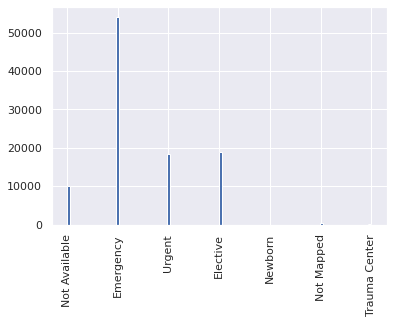

In [32]:
_ = plt.hist(df.admission_type_id, bins=100)
_ = plt.xticks(rotation='vertical')

- `discharge_disposition_id` - patient discharge details if applicable

In [33]:
id_mappings['discharge_disposition_id'].description.unique()

array(['Discharged to home',
       'Discharged/transferred to another short term hospital',
       'Discharged/transferred to SNF', 'Discharged/transferred to ICF',
       'Discharged/transferred to another type of inpatient care institution',
       'Discharged/transferred to home with home health service',
       'Left AMA',
       'Discharged/transferred to home under care of Home IV provider',
       'Admitted as an inpatient to this hospital',
       'Neonate discharged to another hospital for neonatal aftercare',
       'Expired',
       'Still patient or expected to return for outpatient services',
       'Hospice / home', 'Hospice / medical facility',
       'Discharged/transferred within this institution to Medicare approved swing bed',
       'Discharged/transferred/referred another institution for outpatient services',
       'Discharged/transferred/referred to this institution for outpatient services',
       nan, 'Expired at home. Medicaid only, hospice.',
       'Expired

In [34]:
df['discharge_disposition_id'] = df.discharge_disposition_id.map(dict(zip(id_mappings['discharge_disposition_id'].discharge_disposition_id, id_mappings['discharge_disposition_id'].description)))
df.loc[df.discharge_disposition_id.isnull(), 'discharge_disposition_id'] = 'Unknown/Invalid'
df['discharge_disposition_id'] = df.discharge_disposition_id.astype('category')
df.discharge_disposition_id.value_counts(normalize=True)

Discharged to home                                                                                           0.591887
Discharged/transferred to SNF                                                                                0.137118
Discharged/transferred to home with home health service                                                      0.126781
Unknown/Invalid                                                                                              0.036269
Discharged/transferred to another short term hospital                                                        0.020911
Discharged/transferred to another rehab fac including rehab units of a hospital .                            0.019584
Expired                                                                                                      0.016135
Discharged/transferred to another type of inpatient care institution                                         0.011635
Not Mapped                                              

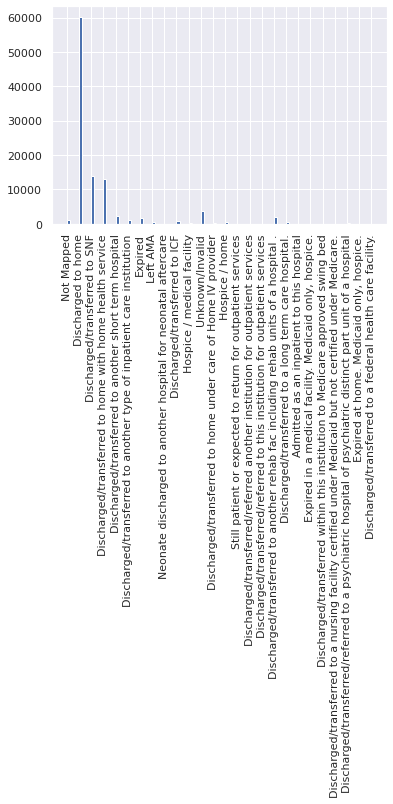

In [35]:
_ = plt.hist(df.discharge_disposition_id, bins=100)
_ = plt.xticks(rotation='vertical')

- `admission_source_id` - Description of where the patient was admitted from for encounter

In [36]:
id_mappings['admission_source_id'].description.unique()

array(['Physician Referral', 'Clinic Referral', 'HMO Referral',
       'Transfer from a hospital',
       'Transfer from a Skilled Nursing Facility (SNF)',
       'Transfer from another health care facility', 'Emergency Room',
       'Court/Law Enforcement', 'Not Available',
       'Transfer from critial access hospital', 'Normal Delivery',
       'Premature Delivery', 'Sick Baby', 'Extramural Birth', nan,
       'Transfer From Another Home Health Agency',
       'Readmission to Same Home Health Agency', 'Not Mapped',
       'Unknown/Invalid',
       'Transfer from hospital inpt/same fac reslt in a sep claim',
       'Born inside this hospital', 'Born outside this hospital',
       'Transfer from Ambulatory Surgery Center', 'Transfer from Hospice'],
      dtype=object)

In [37]:
df['admission_source_id'] = df.admission_source_id.map(dict(zip(id_mappings['admission_source_id'].admission_source_id, id_mappings['admission_source_id'].description)))
df.loc[df.admission_source_id.isnull(), 'admission_source_id'] = 'Not Available'
df['admission_source_id'] = df.admission_source_id.astype('category')
df.admission_source_id.value_counts(normalize=True)

Emergency Room                                               0.564963
Physician Referral                                           0.290519
Not Available                                                0.067862
Transfer from a hospital                                     0.031317
Transfer from another health care facility                   0.022247
Clinic Referral                                              0.010848
Transfer from a Skilled Nursing Facility (SNF)               0.008402
HMO Referral                                                 0.001838
Not Mapped                                                   0.001582
Court/Law Enforcement                                        0.000157
Transfer from hospital inpt/same fac reslt in a sep claim    0.000118
Transfer from critial access hospital                        0.000079
Extramural Birth                                             0.000020
Normal Delivery                                              0.000020
Transfer from Ambula

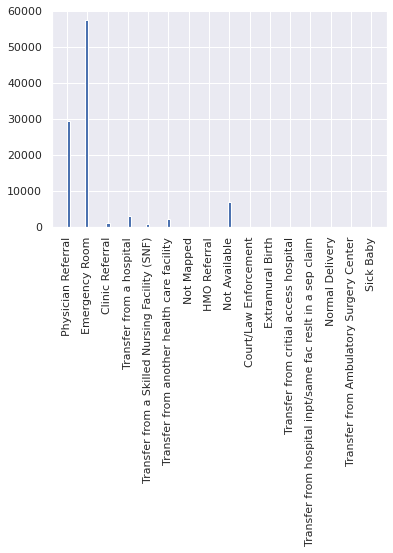

In [38]:
_ = plt.hist(df.admission_source_id, bins=100)
_ = plt.xticks(rotation='vertical')

- `diag_1`, `diag_2`, `diag_3` - The primary, secondary, and tertiary diagnoses for the patient

These are nominal values that are represented by distinct integer values. We should convert these to categorical.

In [39]:
df['diag_1'] = df['diag_1'].astype('category')
df['diag_2'] = df['diag_2'].astype('category')
df['diag_3'] = df['diag_3'].astype('category')

- `gender` - The gender of the patient

In [40]:
df.gender.value_counts(normalize=True)

Female             0.537586
Male               0.462384
Unknown/Invalid    0.000029
Name: gender, dtype: float64

In [41]:
df[df.gender == 'Unknown/Invalid']

,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
98634858,100695042,Other,Unknown/Invalid,7,Elective,Discharged to home,Physician Referral,1,NA,Cardiology,5,5,22,0,0,0,414,411,401,4,Not Available,Not Available,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,1,1,NO
226864668,60524946,Not Available,Unknown/Invalid,6,Emergency,Discharged to home,Emergency Room,1,CP,Not Available,38,1,6,0,0,0,808,873,E813,5,Not Available,Not Available,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0,NO
257364294,78119847,Not Available,Unknown/Invalid,7,Emergency,Discharged/transferred to another rehab fac in...,Emergency Room,8,CP,Not Available,59,2,21,0,0,0,850,805,808,9,Not Available,Not Available,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,1,1,NO


In [42]:
df['gender'] = df.gender.astype('category')

- `race` - The race/ethnicity of the patient

In [43]:
df.race.value_counts(normalize=True)

Caucasian          0.747784
AfricanAmerican    0.188766
Not Available      0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64

In [44]:
df['race'] = df.race.astype('category')

- `readmitted` - if the patient was readmitted back into the hospital {NO (not readmitted), <30 (readmitted within less than days, >30 (readmitted after more than 30 days)}

In [45]:
df.readmitted.value_counts(normalize=True)

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64

In [46]:
df['is_readmitted'] = df['readmitted']
df.loc[df.is_readmitted == 'NO', 'is_readmitted'] = 0
df.loc[((df.is_readmitted == '>30') | (df.is_readmitted == '<30')), 'is_readmitted'] = 1
df['is_readmitted'] = df.is_readmitted.astype(int)

df['is_readmitted_early'] = df['readmitted']
df.loc[((df.is_readmitted_early == 'NO') | (df.is_readmitted_early == '>30')), 'is_readmitted_early'] = 0
df.loc[df.is_readmitted_early == '<30', 'is_readmitted_early'] = 1
df['is_readmitted_early'] = df.is_readmitted_early.astype(int)

In [47]:
df['readmitted'] = df.readmitted.astype('category')

- `max_glu_serum` - Results for a test to measure the amount of glucose in the patient's blood (milligrams/deciliter), e.g. {None (test not taken), Norm (normal level of blood glucose), >200 (mg/dL), >300 (mg/dL)}. A glucose level over 200 mg/dL typically indicates diabetes.

In [48]:
df.max_glu_serum.value_counts(normalize=True)

Not Available    0.947468
Norm             0.025519
>200             0.014592
>300             0.012421
Name: max_glu_serum, dtype: float64

### 5. Handling Outliers for Numerical Features
- `time_in_hospital` - The number of days patient was in the hospital

We should rename this column for more clarity.

In [49]:
df = df.rename(columns={'time_in_hospital': 'days_in_hospital'})

Let's see a statistical summary for our numerical features:

In [50]:
numerical_features = df._get_numeric_data().drop(columns=['patient_nbr', 'is_readmitted', 'is_readmitted_early'])
numerical_features.describe()

,age,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,6.096702,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.594084,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,5.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,6.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,9.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


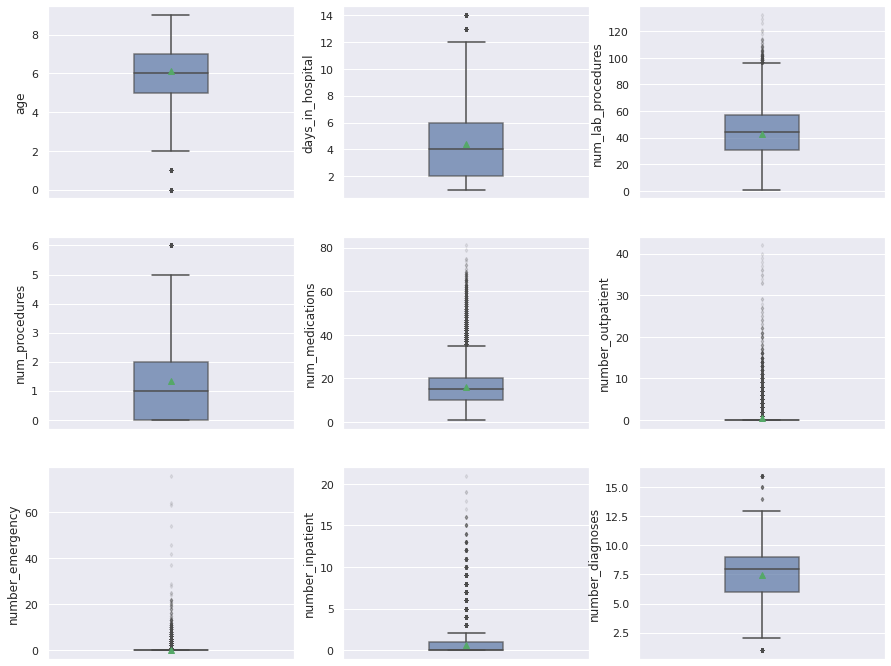

In [51]:
fig, axes = plt.subplots(3, 3)
fig.set_figheight(12)
fig.set_figwidth(15)

for i, c in enumerate(numerical_features.columns):
    _ = sns.boxplot(y=c, data=numerical_features, ax=axes[i//3, i%3],
                    showmeans=True, boxprops=dict(alpha=.7), width=.3,
                    flierprops=dict(markersize=3,alpha=0.1,
              linestyle='none'))

We see an outstanding presence of outliers, especially for features like the number of emergency visits, the number of inpatient and outpatient encounters, the number of medications, and the number of lab procedures. 

In [52]:
def proportion_of_outliers(col):
    """
    Returns the proportion of outliers for a column
    """
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3-q1
    minx = q1 - 1.5*iqr
    maxx = q3 + 1.5*iqr
    return (col[col > maxx].count() + col[col < minx].count()) / len(col)

def outliers_by_iqr(df, feature):
    """
    Returns the portion of a dataframe's feature that consists of outliers
    """
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3-q1
    minx = q1 - 1.5*iqr
    maxx = q3 + 1.5*iqr
    return df[(df[feature] > maxx) | (df[feature] < minx)]

Here's a mapping from feature to its number of outliers:

In [53]:
feature_outliers = dict()
for i, c in enumerate(numerical_features.columns):
    num_outliers = outliers_by_iqr(df, c).shape[0]
    feature_outliers[c] = num_outliers
feature_outliers

{'age': 852,
 'days_in_hospital': 2252,
 'num_lab_procedures': 143,
 'num_procedures': 4954,
 'num_medications': 2557,
 'number_outpatient': 16739,
 'number_emergency': 11383,
 'number_inpatient': 7049,
 'number_diagnoses': 281}

Let's see the proportion of outliers per feature, grouped by early readmission:

In [54]:
cols = list(numerical_features.columns) + ['is_readmitted_early']
df[cols].groupby('is_readmitted_early').apply(lambda x: x.apply(lambda y: proportion_of_outliers(y))).drop(columns=['is_readmitted_early'])

,age,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
is_readmitted_early,,,,,,,,,
0,0.008948,0.021768,0.001405,0.049542,0.024832,0.159918,0.105001,0.057959,0.002887
1,0.003786,0.025007,0.001585,0.041824,0.024302,0.200845,0.166417,0.042177,0.001761


We see that for some features like number of emergency visits, days in the hospital, and number of outpatient visits, there is a difference in the proportion of outliers. I'm hesitant to apply a clamp transformation to limit these outliers just yet, because I'm interested in applying outlier-robust, tree-based algorithms on this untransformed data. However, during the feature engineering phase, I will also apply the clamp transformation to experiment with less robust algorithms.

### 6. Statistical independence
In case we want to use models that require that all observations are statistically independent, we can limit all patients in the dataset to their first inpatient encounter.


In [55]:
single_encounter_df = df.sort_values(by='encounter_id', axis='index').drop_duplicates(subset=['patient_nbr'], keep='first')
single_encounter_df = single_encounter_df.reset_index()
single_encounter_df = single_encounter_df.set_index(['encounter_id', 'patient_nbr'])
single_encounter_df.shape

(71518, 49)

Let's see if this transformation reduces the amount of outliers in the dataset:

In [56]:
feature_outliers = dict()
for i, c in enumerate(numerical_features.columns):
    num_outliers = outliers_by_iqr(single_encounter_df, c).shape[0]
    feature_outliers[c] = num_outliers
feature_outliers

{'age': 689,
 'days_in_hospital': 1464,
 'num_lab_procedures': 114,
 'num_procedures': 3956,
 'num_medications': 1925,
 'number_outpatient': 9306,
 'number_emergency': 5204,
 'number_inpatient': 8441,
 'number_diagnoses': 236}

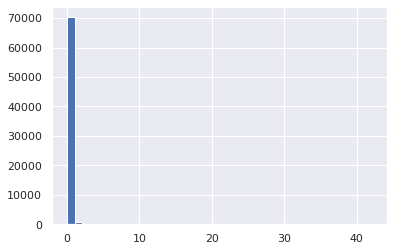

In [57]:
_ = single_encounter_df.number_emergency.hist(bins=40)

In [58]:
single_encounter_df.number_emergency.value_counts()

0     66314
1      3965
2       804
3       246
4        96
5        33
6        26
8         9
7         8
10        5
9         4
11        2
13        1
16        1
20        1
25        1
37        1
42        1
Name: number_emergency, dtype: int64

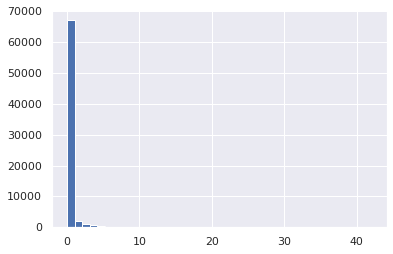

In [59]:
_ = single_encounter_df.number_outpatient.hist(bins=40)

In [60]:
single_encounter_df.number_outpatient.value_counts()

0     62212
1      4867
2      2025
3      1116
4       585
5       288
6       128
7        73
8        57
9        37
10       28
11       19
12       14
13       13
14       10
15       10
16        8
17        4
20        4
18        2
21        2
22        2
24        2
27        2
33        2
19        1
23        1
25        1
26        1
29        1
35        1
36        1
42        1
Name: number_outpatient, dtype: int64

In [61]:
features_with_homogeneity = homogeneous_features(single_encounter_df)
single_encounter_df = single_encounter_df.drop(columns=features_with_homogeneity)
features_with_homogeneity

['examide', 'citoglipton', 'glimepiride-pioglitazone']

### 7. Exporting Preprocessed Data
Save the pre-processed data into a csv and pickle file.

In [62]:
original_shape, df.shape

((101766, 49), (101766, 50))

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 2278392 to 443867222
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   patient_nbr               101766 non-null  int64   
 1   race                      101766 non-null  category
 2   gender                    101766 non-null  category
 3   age                       101766 non-null  int64   
 4   admission_type_id         101766 non-null  category
 5   discharge_disposition_id  101766 non-null  category
 6   admission_source_id       101766 non-null  category
 7   days_in_hospital          101766 non-null  int64   
 8   payer_code                101766 non-null  category
 9   medical_specialty         101766 non-null  category
 10  num_lab_procedures        101766 non-null  int64   
 11  num_procedures            101766 non-null  int64   
 12  num_medications           101766 non-null  int64   
 13  number_outpatient   

In [64]:
df.to_csv(OUTPUT_CSV_FILEPATH)

In [65]:
df.to_pickle(OUTPUT_PICKLE_FILEPATH)

In [66]:
single_encounter_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 71518 entries, (12522, 48330783) to (443867222, 175429310)
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      71518 non-null  category
 1   gender                    71518 non-null  category
 2   age                       71518 non-null  int64   
 3   admission_type_id         71518 non-null  category
 4   discharge_disposition_id  71518 non-null  category
 5   admission_source_id       71518 non-null  category
 6   days_in_hospital          71518 non-null  int64   
 7   payer_code                71518 non-null  category
 8   medical_specialty         71518 non-null  category
 9   num_lab_procedures        71518 non-null  int64   
 10  num_procedures            71518 non-null  int64   
 11  num_medications           71518 non-null  int64   
 12  number_outpatient         71518 non-null  int64   
 13  number_emerge

In [67]:
single_encounter_df.to_csv(OUTPUT_SINGLE_ENCOUNTER_CSV_FILEPATH)

In [68]:
single_encounter_df.to_pickle(OUTPUT_SINGLE_ENCOUNTER_PICKLE_FILEPATH)